In [3]:
# Individual Household Electric Power Consumption
# Young Jason Lee
# Group 6
# SJSU ID: 015293408

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report
import joblib
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
    

In [4]:
def preprocess_data(file_path, resample='H'):
    df = pd.read_csv(file_path, sep=';', low_memory=False)
    
    # Combine date and time into datetime
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
    df.drop(columns=['Date', 'Time'], inplace=True)
    df.set_index('datetime', inplace=True)
    df.dropna(inplace=True)
    numeric_columns = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
                       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
    df_resampled = df.resample(resample).mean()

    df_resampled['hour'] = df_resampled.index.hour
    df_resampled['day_of_week'] = df_resampled.index.dayofweek  # Monday=0, Sunday=6
    
    return df_resampled

C:\Users\Jason\AppData\Local\Temp\ipykernel_11076\877097959.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df.resample(resample).mean()
C:\Users\Jason\AppData\Local\Temp\ipykernel_11076\1698864316.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_2']] = scaler.fit_transform(


Model saved to kmeans_peak_prediction.pkl


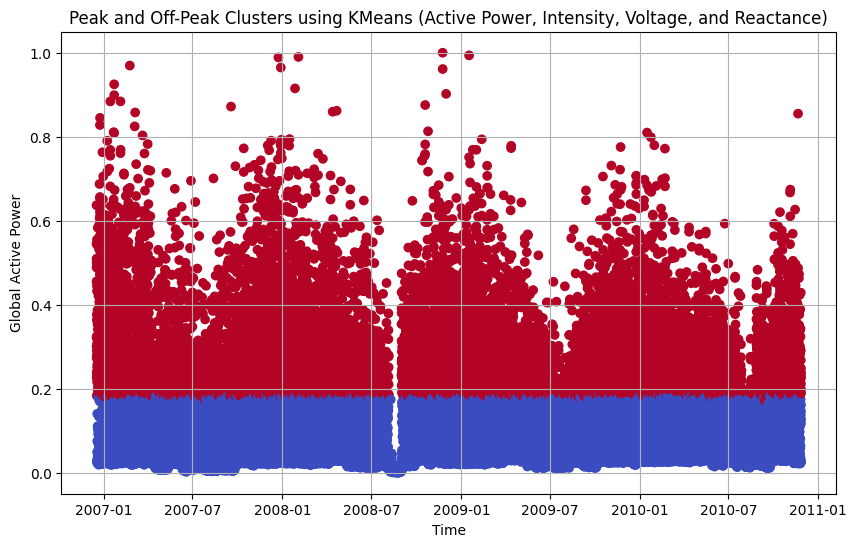

In [6]:
data_path = 'household_power_consumption.txt'
df_hourly = preprocess_data(data_path)

# Delete empty values
df_hourly.dropna(inplace=True)

# clustering_features = ['Global_active_power', 'Global_intensity', 'Voltage', 'Global_reactive_power']
clustering_features = ['Global_active_power', 'Global_intensity']

# Normalize features
scaler = MinMaxScaler()
df_hourly[clustering_features] = scaler.fit_transform(df_hourly[clustering_features])

# Sklearn Kmeans Clustering
kmeans = KMeans(n_clusters=2)
df_hourly['cluster'] = kmeans.fit_predict(df_hourly[clustering_features])

# Determine which cluster corresponds to peak usage
cluster_means = df_hourly.groupby('cluster')['Global_active_power'].mean()
peak_cluster = cluster_means.idxmax()

# Assign peak/off-peak labels
df_hourly['is_peak'] = (df_hourly['cluster'] == peak_cluster).astype(int)

features = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity',
            'Sub_metering_2', 'hour', 'day_of_week']

X = df_hourly[features]
y = df_hourly['is_peak']

# Normalize features
X[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_2']] = scaler.fit_transform(
    X[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_2']])

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, max_depth = 5, min_samples_split=2)
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)

# Save the model
model_path = "kmeans_peak_prediction.pkl"
joblib.dump(clf, model_path)
print(f"Model saved to {model_path}")
plt.figure(figsize=(10, 6))
plt.scatter(df_hourly.index, df_hourly['Global_active_power'], c=df_hourly['is_peak'], cmap='coolwarm')
plt.title("Peak and Off-Peak Clusters using KMeans (Active Power, Intensity, Voltage, and Reactance)")
plt.xlabel("Time")
plt.ylabel("Global Active Power")
plt.grid(True)
plt.show()


In [7]:
# Load the trained model
model_path = "kmeans_peak_prediction.pkl"
clf = joblib.load(model_path)

# Load the test dataset
test_data_path = 'household_power_consumption_2009.txt'
test_df = preprocess_data(test_data_path)

C:\Users\Jason\AppData\Local\Temp\ipykernel_11076\877097959.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df.resample(resample).mean()


Predicted Off-Peak Hours for 2009-08-25:
                     hour  Global_active_power
datetime                                      
2009-08-25 00:00:00     0             0.048097
2009-08-25 01:00:00     1             0.027782
2009-08-25 02:00:00     2             0.021115
2009-08-25 03:00:00     3             0.027934
2009-08-25 04:00:00     4             0.017908
2009-08-25 05:00:00     5             0.024748
2009-08-25 06:00:00     6             0.081542
2009-08-25 08:00:00     8             0.037593
2009-08-25 09:00:00     9             0.026572
2009-08-25 10:00:00    10             0.137620
2009-08-25 11:00:00    11             0.027188
2009-08-25 12:00:00    12             0.016614
2009-08-25 13:00:00    13             0.024916
2009-08-25 14:00:00    14             0.023328
2009-08-25 15:00:00    15             0.016215
2009-08-25 16:00:00    16             0.030279
2009-08-25 17:00:00    17             0.018712
2009-08-25 18:00:00    18             0.092010
2009-08-25 22:00:00

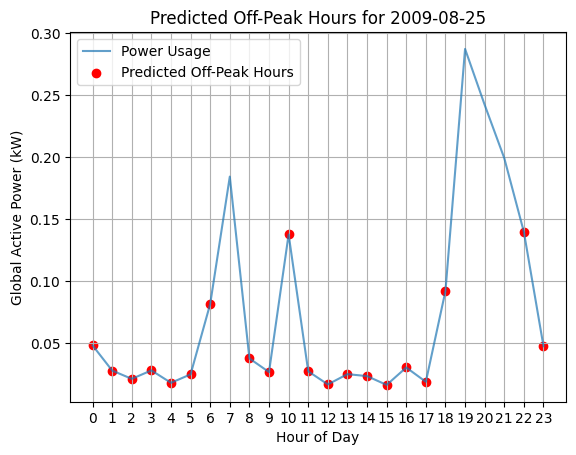

In [8]:
features = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_2', 'hour', 'day_of_week']

# Normalize data using min-max scaler
scaler = MinMaxScaler()
test_df[features[:-2]] = scaler.fit_transform(test_df[features[:-2]])

# Predict peak/off-peak
test_df['is_peak_prediction'] = clf.predict(test_df[features])

# Select a random day in the dataset
random_date = random.choice(test_df.index.date)
random_day_data = test_df[test_df.index.date == random_date]

# Extract off-peak hours for the random day
off_peak_hours = random_day_data[random_day_data['is_peak_prediction'] == 0]

# Output predicted off-peak hours
print(f"Predicted Off-Peak Hours for {random_date}:")
if not off_peak_hours.empty:
    print(off_peak_hours[['hour', 'Global_active_power']])
else:
    print("No Off-Peak hours predicted for this day.")

plt.plot(random_day_data.index.hour, random_day_data['Global_active_power'], label='Power Usage', alpha=0.7)
plt.scatter(
    off_peak_hours.index.hour,
    off_peak_hours['Global_active_power'],
    color='red',
    label='Predicted Off-Peak Hours'
)
plt.title(f'Predicted Off-Peak Hours for {random_date}')
plt.xlabel('Hour of Day')
plt.ylabel('Global Active Power (kW)')
plt.xticks(range(0, 24, 1))  # Display all hours on the x-axis
plt.legend()
plt.grid(True)
plt.show()


In [9]:
# Load trained model
model_path = "kmeans_peak_prediction.pkl"
clf = joblib.load(model_path)

# Load dataset for historical data
data_path = 'household_power_consumption.txt'
df = preprocess_data(data_path)

C:\Users\Jason\AppData\Local\Temp\ipykernel_11076\877097959.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df.resample(resample).mean()


Choose a day to evaluate:
0: Monday
1: Tuesday
2: Wednesday
3: Thursday
4: Friday
5: Saturday
6: Sunday


Enter the day you want to evaluate for off-peak usage(0 for Monday, 6 for Sunday):  3


Typical Off-Peak Hours for Thursday:
    hour  Global_active_power
0      0             0.110479
1      1             0.043503
2      2             0.024911
3      3             0.000000
4      4             0.017497
5      5             0.030178
15    15             0.159552
16    16             0.150622


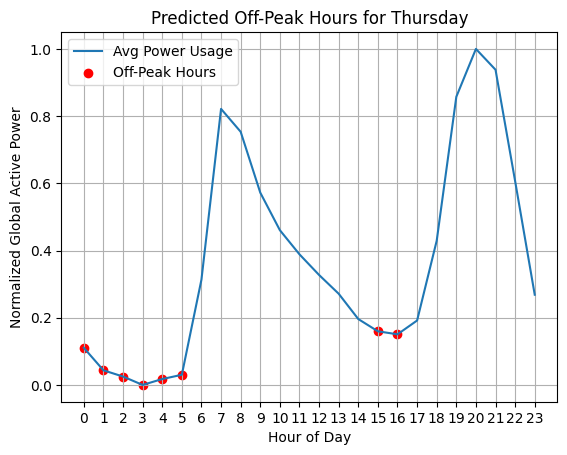

In [10]:
# Script to evaluate active power usage based on historical usage
day_map = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}
print("Choose a day to evaluate:")
for key, value in day_map.items():
    print(f"{key}: {value}")
chosen_day = int(input("Enter the day you want to evaluate for off-peak usage(0 for Monday, 6 for Sunday): "))
day_filter = df['day_of_week'] == chosen_day
df_filtered = df[day_filter]

# Calculate average power usage based on day
historical_usage = df_filtered.groupby('hour').mean().reset_index()

# Normalize the data
scaler = MinMaxScaler()
features = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_2']
historical_usage[features] = scaler.fit_transform(historical_usage[features])
historical_usage['day_of_week'] = chosen_day

# Predict off-peak hours during the day
historical_usage['is_peak_prediction'] = clf.predict(historical_usage[features + ['hour', 'day_of_week']])
off_peak_hours = historical_usage[historical_usage['is_peak_prediction'] == 0]
    
# Print off-peak hours
print(f"Typical Off-Peak Hours for {day_map[chosen_day]}:")
if not off_peak_hours.empty:
    print(off_peak_hours[['hour', 'Global_active_power']])
else:
    print("No Off-Peak hours were identified for this day.")
    
plt.plot(historical_usage['hour'], historical_usage['Global_active_power'], label='Avg Power Usage')
plt.scatter(
    off_peak_hours['hour'],
    off_peak_hours['Global_active_power'],
    color='red',
    label='Off-Peak Hours'
)
plt.title(f'Predicted Off-Peak Hours for {day_map[chosen_day]}')
plt.xlabel('Hour of Day')
plt.ylabel('Normalized Global Active Power')
plt.xticks(range(0, 24, 1))
plt.legend()
plt.grid(True)
plt.show()


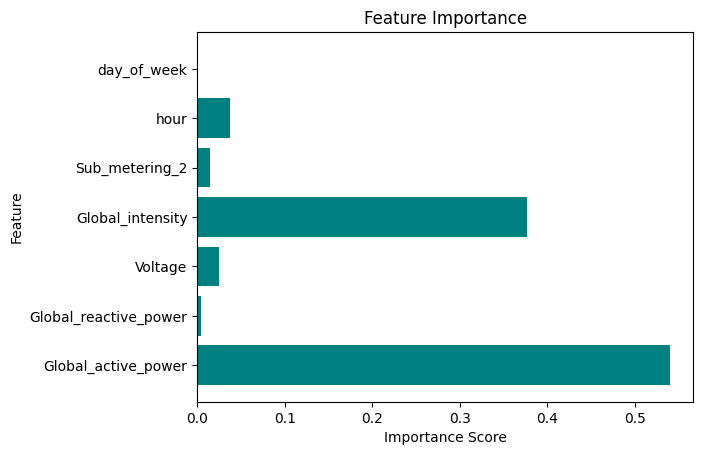

In [11]:
importances = clf.feature_importances_
feature_names = X.columns
plt.barh(feature_names, importances, color="teal")
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


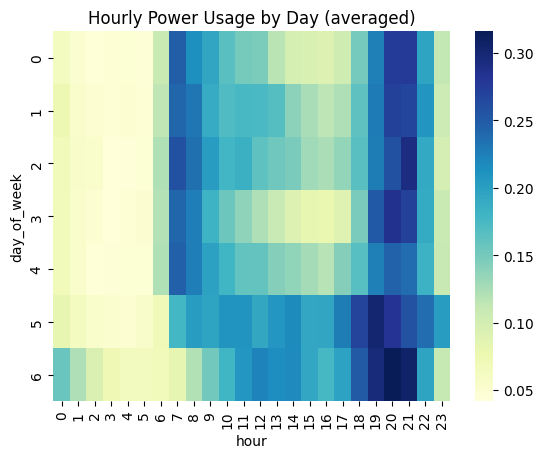

In [12]:


heatmap_data = df_hourly.pivot_table(values='Global_active_power', index='day_of_week', columns='hour', aggfunc='mean')
heatmap_data = heatmap_data.fillna(0)

sns.heatmap(heatmap_data, cmap="YlGnBu", annot=False)
plt.title("Hourly Power Usage by Day (averaged)")
plt.show()


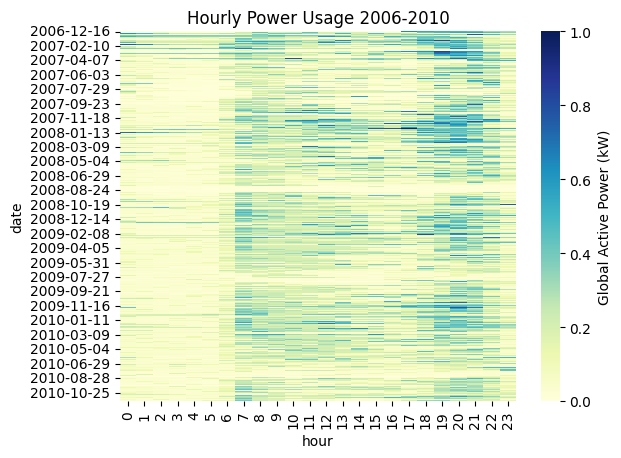

In [13]:
df_hourly['date'] = df_hourly.index.date
df_hourly['hour'] = df_hourly.index.hour

heatmap_data_full = df_hourly.pivot_table(values='Global_active_power', index='date', columns='hour', aggfunc='mean')
heatmap_data_full = heatmap_data_full.fillna(0)

sns.heatmap(heatmap_data_full, cmap="YlGnBu", cbar_kws={'label': 'Global Active Power (kW)'})
plt.title("Hourly Power Usage 2006-2010")
plt.show()


In [14]:
def plot_data(df, column):
    df = df[df.index.year > 2006]
    years = sorted(df.index.year.unique())
    fig, axes = plt.subplots(len(years), 1, figsize=(14, 4), sharex=True, sharey=True)
    fig.suptitle(f'Yearly Analysis: {column}')

    for i, year in enumerate(years):
        yearly_data = df[df.index.year == year]
        axes[i].plot(yearly_data.index.day_of_year, yearly_data[column], label=str(year))
        axes[i].legend(loc='upper right')
        axes[i].grid(True)

    axes[-1].set_xticks(
        [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
    )
    axes[-1].set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                              "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
    axes[-1].set_xlabel('Month')
    plt.show()

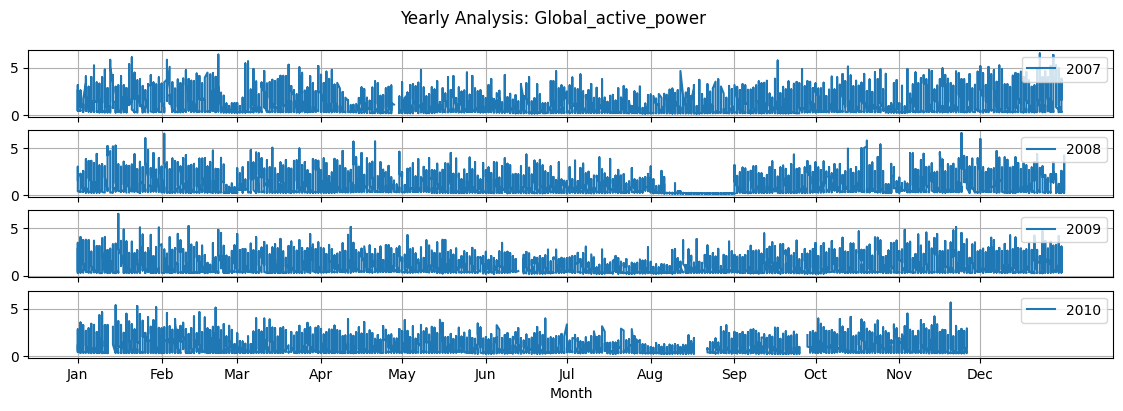

In [15]:
plot_data(df, 'Global_active_power')

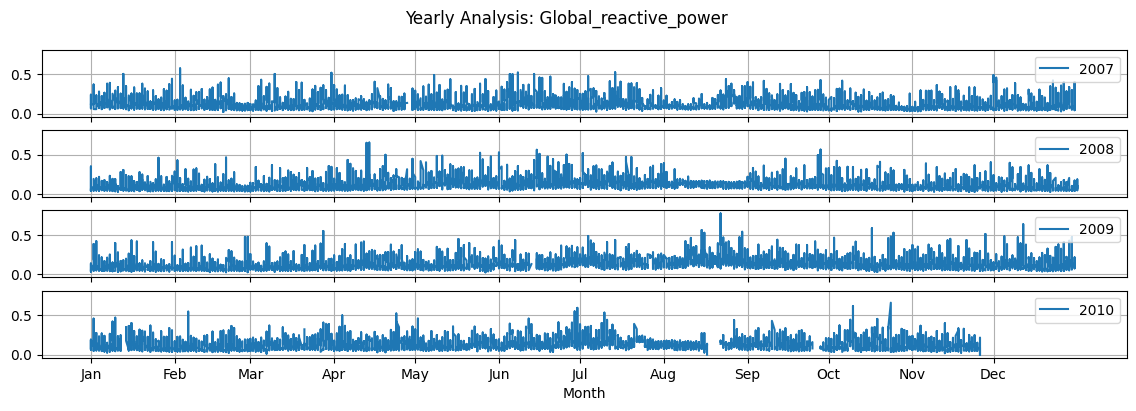

In [16]:
plot_data(df, 'Global_reactive_power')

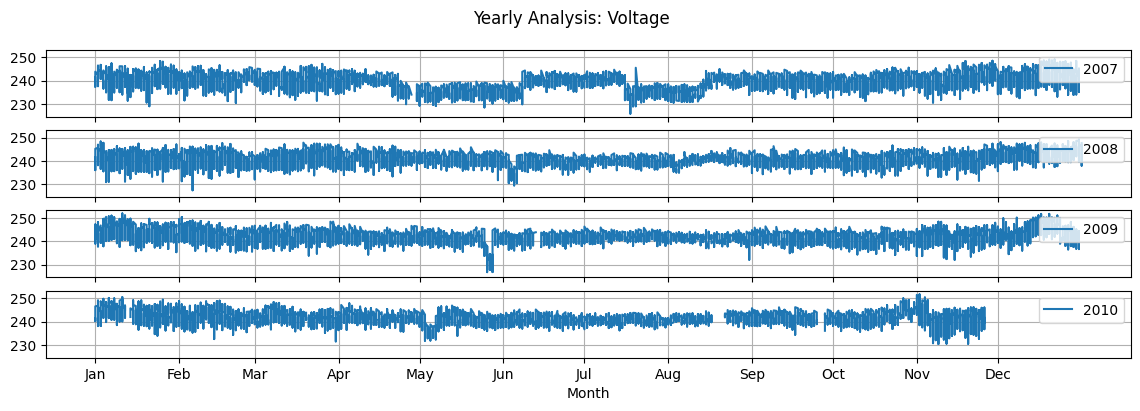

In [17]:
plot_data(df, 'Voltage')

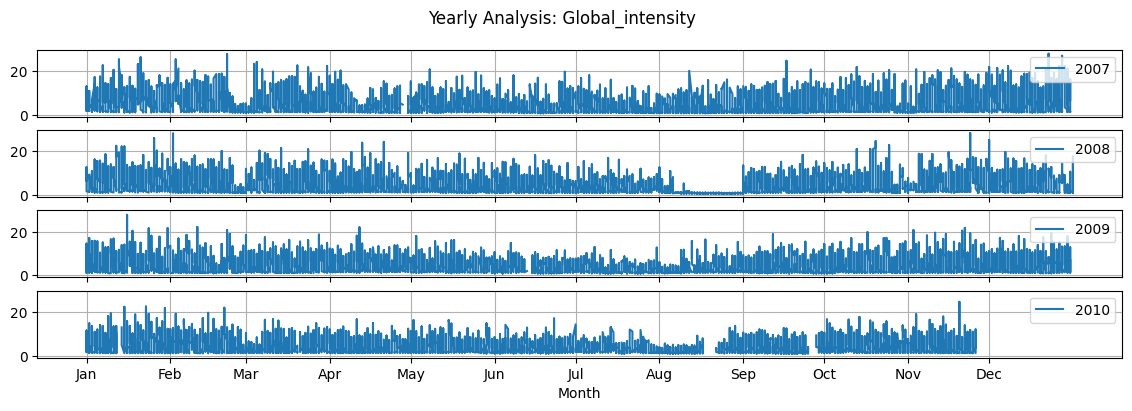

In [18]:
plot_data(df, 'Global_intensity')

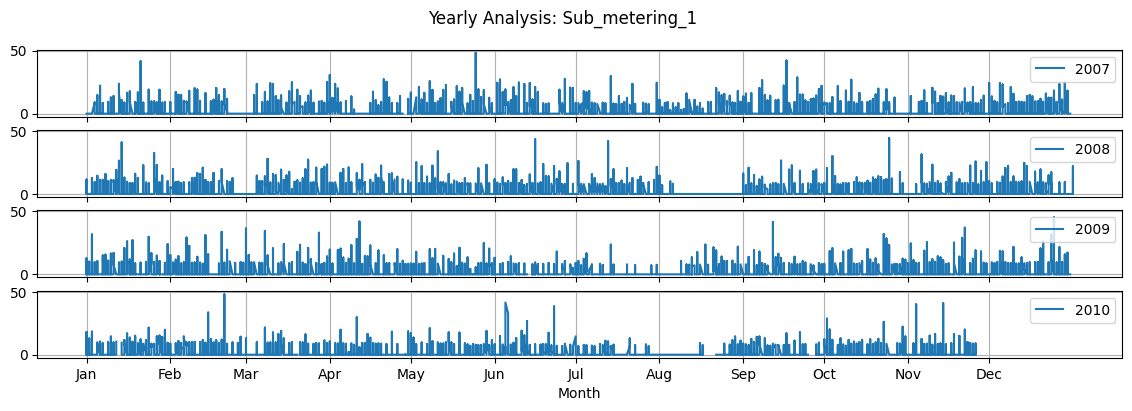

In [19]:
plot_data(df, 'Sub_metering_1')

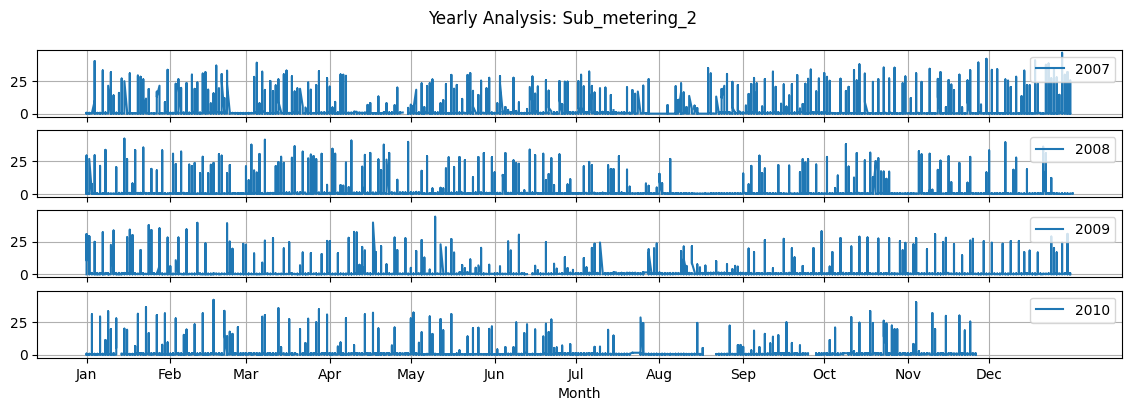

In [20]:
plot_data(df, 'Sub_metering_2')

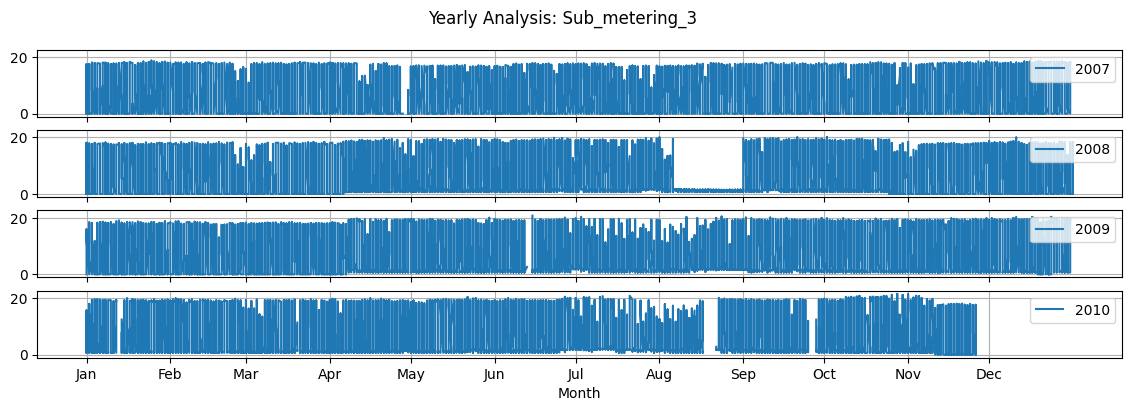

In [21]:
plot_data(df, 'Sub_metering_3')

<Figure size 800x600 with 0 Axes>

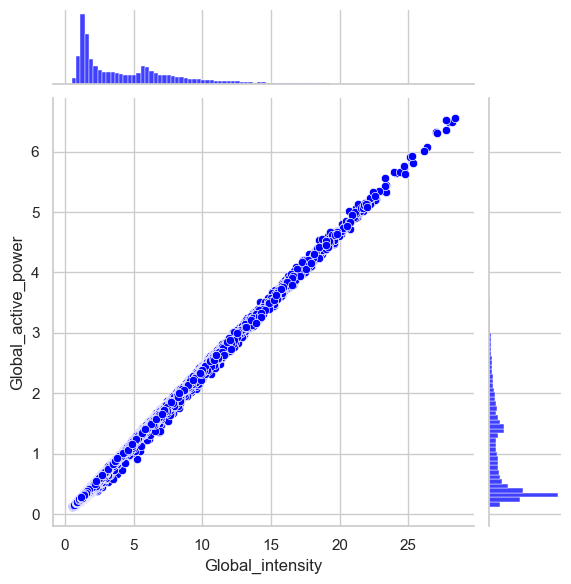

In [22]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.jointplot(x='Global_intensity', y='Global_active_power', data=df, kind='scatter', color='blue')
plt.show()